In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
from sklearn.decomposition import PCA


In [2]:
df = pd.read_csv("churn-bigml-80.csv")

if "df" not in globals():
    raise RuntimeError("DataFrame 'df' not found. Load your dataset into variable df before running this cell.")

if "Churn" in df.columns:
    target_col = "Churn"
else:
    binary_cols = [c for c in df.columns if df[c].nunique() == 2]
    if not binary_cols:
        raise RuntimeError("No binary target column found. Provide df with a binary target or a 'Churn' column.")
    target_col = binary_cols[0]

df[target_col] = df[target_col].astype(int)

cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
for c in cat_cols:
    df[c] = LabelEncoder().fit_transform(df[c])

X = df.drop(columns=[target_col])
y = df[target_col]


In [3]:
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()
X_scaled = X.copy()
if num_cols:
    X_scaled[num_cols] = scaler.fit_transform(X[num_cols])

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


In [4]:
svm_linear = SVC(kernel="linear", probability=True, random_state=42)
svm_rbf = SVC(kernel="rbf", probability=True, random_state=42)

svm_linear.fit(X_train, y_train)
svm_rbf.fit(X_train, y_train)


SVC(probability=True, random_state=42)

In [5]:
models = {"SVM-linear": svm_linear, "SVM-rbf": svm_rbf}
results = {}

for name, m in models.items():
    y_pred = m.predict(X_test)
    y_prob = m.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_prob)
    results[name] = {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "auc": auc}
    print(name)
    print(f"Accuracy: {acc:.4f}  Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}  AUC: {auc:.4f}")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("-" * 60)


SVM-linear
Accuracy: 0.8539  Precision: 0.0000  Recall: 0.0000  F1: 0.0000  AUC: 0.7492
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       456
           1       0.00      0.00      0.00        78

    accuracy                           0.85       534
   macro avg       0.43      0.50      0.46       534
weighted avg       0.73      0.85      0.79       534

------------------------------------------------------------
SVM-rbf
Accuracy: 0.8989  Precision: 0.8000  Recall: 0.4103  F1: 0.5424  AUC: 0.8591
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       456
           1       0.80      0.41      0.54        78

    accuracy                           0.90       534
   macro avg       0.85      0.70      0.74       534
weighted avg       0.89      0.90      0.88       534

------------------------------------------------------------


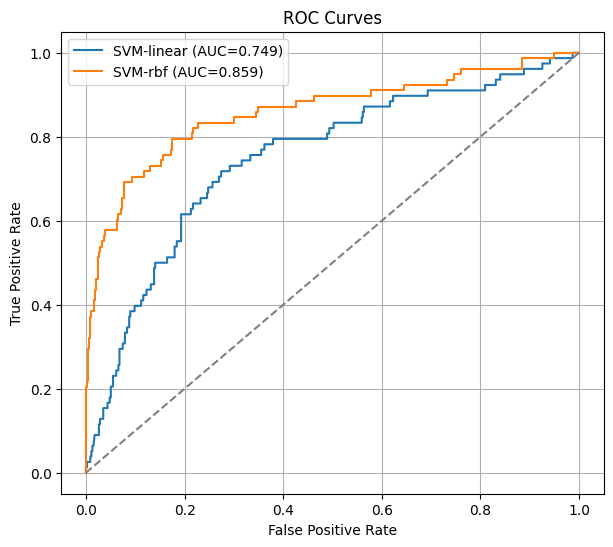

In [6]:
plt.figure(figsize=(7,6))
for name, m in models.items():
    y_prob = m.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_val = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.3f})")

plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid(True)
plt.show()


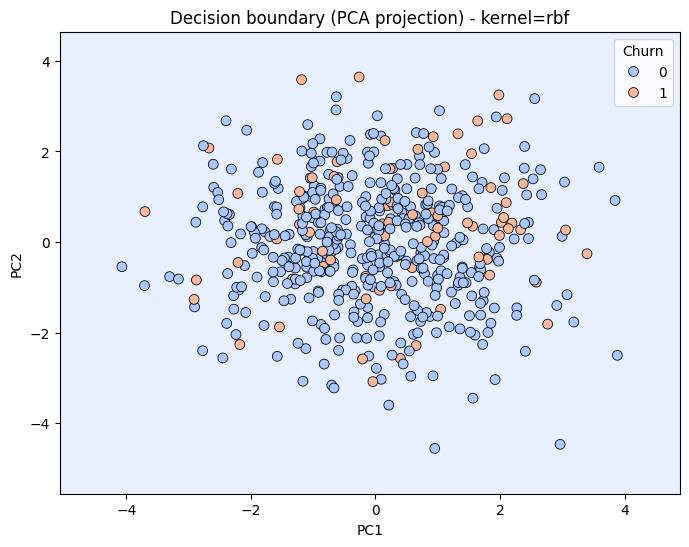

In [7]:
pca = PCA(n_components=2, random_state=42)
X_train_2d = pca.fit_transform(X_train)
X_test_2d = pca.transform(X_test)

m = svm_rbf
m_2d = SVC(kernel=m.kernel, probability=True, random_state=42)
m_2d.fit(X_train_2d, y_train)

x_min, x_max = X_test_2d[:,0].min() - 1, X_test_2d[:,0].max() + 1
y_min, y_max = X_test_2d[:,1].min() - 1, X_test_2d[:,1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = m_2d.predict(grid).reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.2, cmap="coolwarm")
sns.scatterplot(x=X_test_2d[:,0], y=X_test_2d[:,1], hue=y_test, palette="coolwarm", s=50, edgecolor="k")
plt.title(f"Decision boundary (PCA projection) - kernel={m.kernel}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title=target_col)
plt.show()
